# Task 3

In [124]:
# packages
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import try_all_threshold

In this task, the goal is to use traditional CV methods to segment five individual plants (not plant organs) from given images.

### Disclaimer! 

#### Process of forming final answer

This notebook will follow the logic of forming the final answer, as well as contain the desired output for the intended goal.

# Phase 1: Testing

## 1. Importing the images

First we load the image from the database.

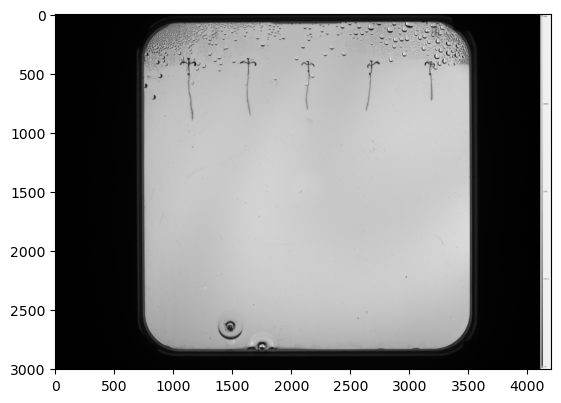

In [125]:
# IMAGE TO BE USED FOR TESTING
image_path = "/Volumes/Capybara/2024-25b-fai2-adsai-dariavladutu236578/datalab_tasks/task3/task_3_image_1.png"
im = cv2.imread(image_path, 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)
plt.imshow(im, cmap='gray')

#### Crop image (using task 2 function)

In [126]:
def crop_image (image):
    # read the image in grayscale
    im = cv2.imread(image, 0)

    # apply Gaussian Blur
    blur = cv2.GaussianBlur(im, (5,5), 0)

    # threshold the image to detect the edges of the Petri dish
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # select the largest contour (assume that is the pietri dish)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]

    # get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # ensure the bounding box is square
    square_size = max(w, h)

    # ensure the bounding box is centered
    x_center = x + w // 2
    y_center = y + h // 2

    x_start = max(x_center - square_size // 2, 0)
    y_start = max(y_center - square_size // 2, 0)

    # crop the image
    cropped_image = im[y_start:y_start+square_size, x_start:x_start+square_size]

    return cropped_image

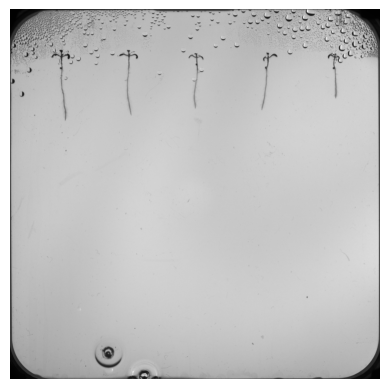

In [127]:
# Apply function
cropped = crop_image(image_path)

# Display the cropped image
plt.imshow(cropped, cmap='gray')
plt.axis('off')
plt.show()

## 2. Reduce noise

Here, I tested 2 different types of noise reduction techniques to see which one works better. My initial hypothesis was that Gaussian blur would perform better because I saw that is the smoothing techniques. However, I wanted to convince myself so.

### Gaussian blur

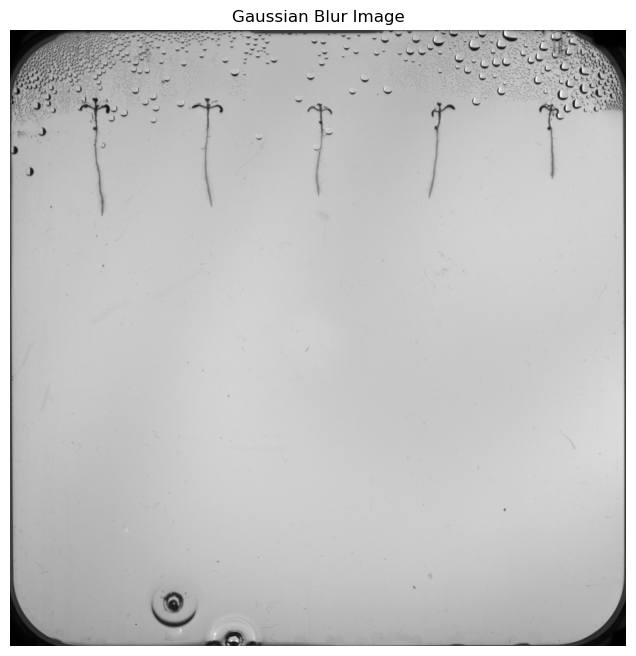

In [128]:
# Assume cropped_image is already available from previous steps
gblur_img = cv2.GaussianBlur(cropped, (3, 3), 0)

# Display the blurred image
plt.figure(figsize=(8,8))
plt.imshow(gblur_img, cmap='gray')
plt.title("Gaussian Blur Image")
plt.axis('off')
plt.show()

### Median blur

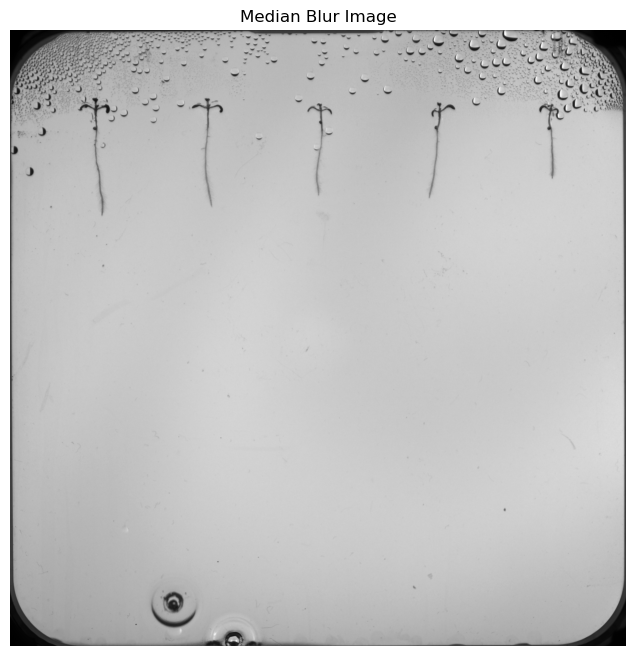

In [129]:
# Assume cropped_image is already available from previous steps
mblur_img = cv2.medianBlur(cropped, ksize=3)

# Display the blurred image
plt.figure(figsize=(8,8))
plt.imshow(mblur_img, cmap='gray')
plt.title("Median Blur Image")
plt.axis('off')
plt.show()

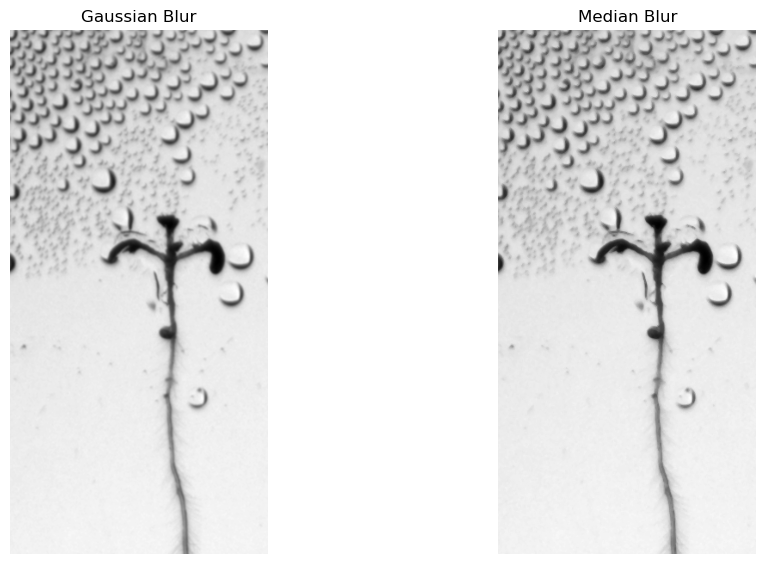

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Gaussian blurred image
cropped_img = gblur_img[90:700, 200:500]
axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title('Gaussian Blur')
axs[0].axis('off')

# Plot Median blurred image
cropped_img = mblur_img[90:700, 200:500]
axs[1].imshow(cropped_img, cmap='gray')
axs[1].set_title('Median Blur')
axs[1].axis('off')

plt.tight_layout(pad=2)
plt.show()

In this case, the **Median Blur** is actually better (based on visual comparisons) because it preservers plant contours and root details more clearly, and because it remove background noise without over-smoothing like the **Gaussian Blur**.

### Gaussian-Median mix

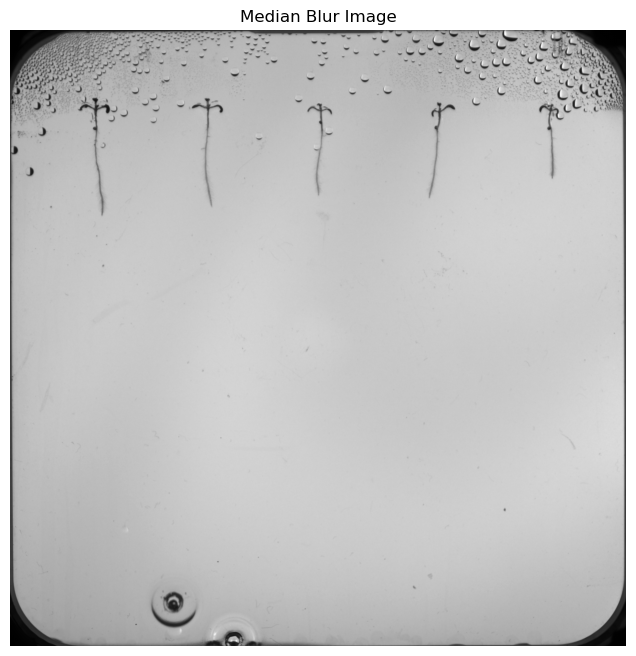

In [148]:
combo = cv2.GaussianBlur(mblur_img, (3, 3), 0)

# Display the blurred image
plt.figure(figsize=(8,8))
plt.imshow(combo, cmap='gray')
plt.title("Median Blur Image")
plt.axis('off')
plt.show()

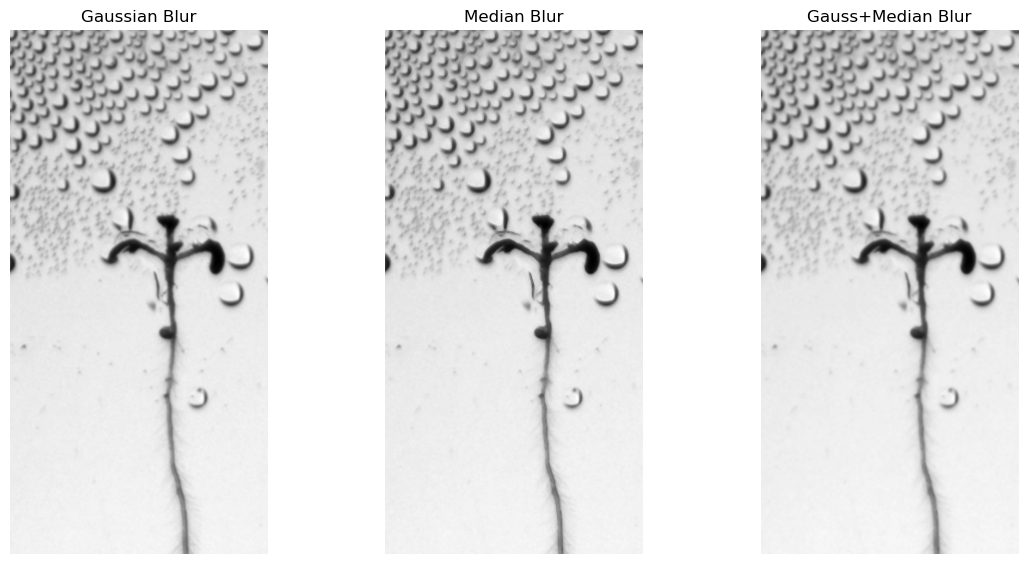

In [132]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Plot Gaussian blurred image
cropped_img = gblur_img[90:700, 200:500]
axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title('Gaussian Blur')
axs[0].axis('off')

# Plot Median blurred image
cropped_img = mblur_img[90:700, 200:500]
axs[1].imshow(cropped_img, cmap='gray')
axs[1].set_title('Median Blur')
axs[1].axis('off')

# # Plot Mixed blurred image
cropped_img = combo[90:700, 200:500]
axs[2].imshow(cropped_img, cmap='gray')
axs[2].set_title('Gauss+Median Blur')
axs[2].axis('off')

plt.tight_layout(pad=2)
plt.show()

Yet after we combine the situations, we can see that the **Median + Gaussian combo** combines denoising and edge retention better.

---

*Winner: Median+Gaussian combo*

## 3. Thresholding

Based on observing the different thresholding methods in the task_2.ipynb, the Otsu method was the best performing one. So, I decided to compare it against adaptive thresholding. Additionally, I also decided to see how these thresholding methods apply to each individual noise reduction step described in the previous section.

### Otsu thresholding

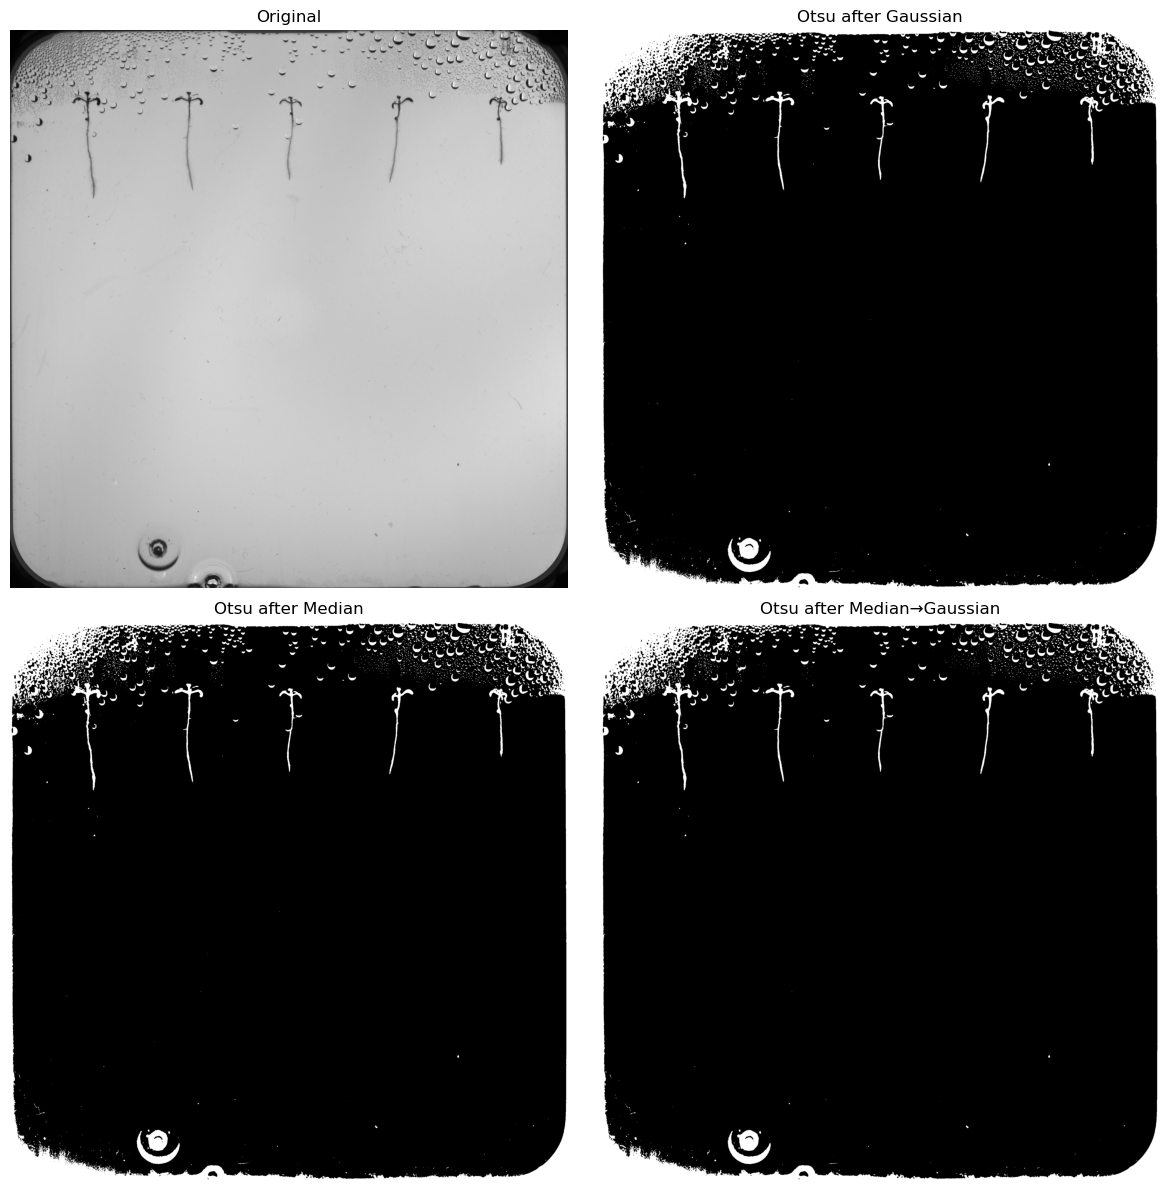

In [133]:
# 1. Gaussian Blur → Otsu
_, othresh_gauss = cv2.threshold(gblur_img, 164, 255, cv2.THRESH_BINARY_INV)

# 2. Median Blur → Otsu
_, othresh_median = cv2.threshold(mblur_img, 164, 255, cv2.THRESH_BINARY_INV)

# 3. Median → Gaussian → Otsu
_, othresh_combo = cv2.threshold(combo, 164, 255, cv2.THRESH_BINARY_INV)

# Display
titles = ['Original', 'Otsu after Gaussian', 'Otsu after Median', 'Otsu after Median→Gaussian']
images = [cropped, othresh_gauss, othresh_median, othresh_combo]

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

The winner here is definetly the **Otsu after Gaussian** because it has the most clearly defined roots and a 'crisp' background.

### Adaptive thresholding

In [134]:
# Helper function for adaptive thresholding (block size = 21, constant =7 )
def adaptive_thresh(img):
    return cv2.adaptiveThreshold(
        img, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        21, 7 
    )

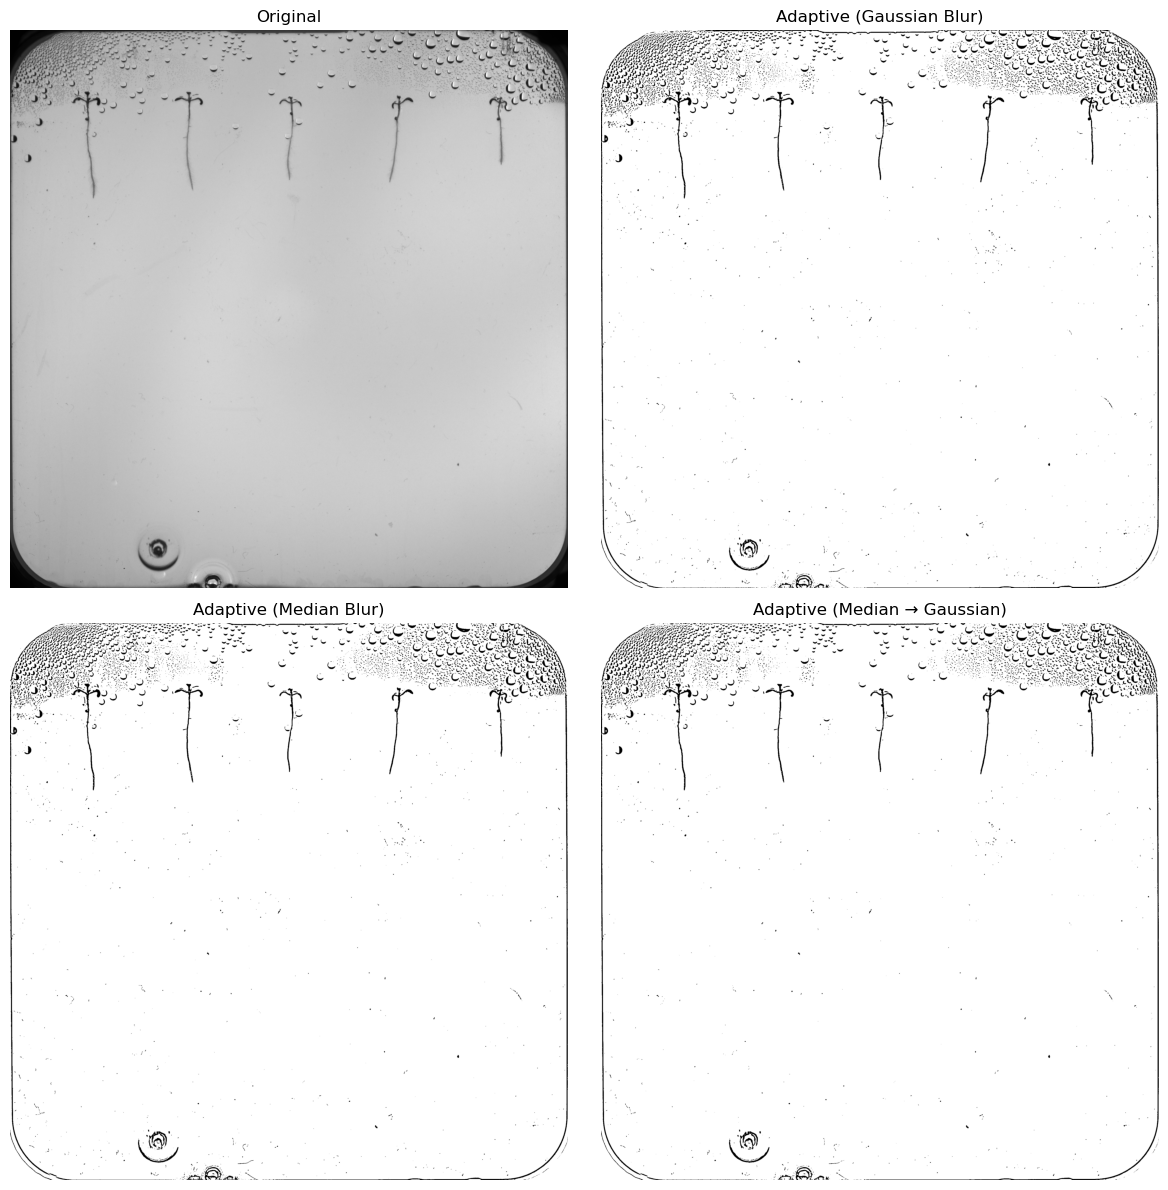

In [135]:
# 1. Gaussian Blur → Adaptive Threshold
thresh_gauss = adaptive_thresh(gblur_img)

# 2. Median Blur → Adaptive Threshold
thresh_median = adaptive_thresh(mblur_img)

# 3. Median → Gaussian → Adaptive Threshold)
thresh_combo = adaptive_thresh(combo)

# Display
titles = ['Original', 'Adaptive (Gaussian Blur)', 'Adaptive (Median Blur)', 'Adaptive (Median → Gaussian)']
images = [cropped, thresh_gauss, thresh_median, thresh_combo]

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

The **Median + Gaussian** example has the best combination of contrast, clarity, and background cleanup, visually having having the least 'salt-and-pepper' effect.

---

*Winner: Median + Gaussian (strong root contrast)*

## 4. Morphological Operations

After the Hunger games I just performed, I will move forward with the following methods: **Adaptive threshold on the Median + Gauss combo**.

Playing around with different operations.

### Open/ Close

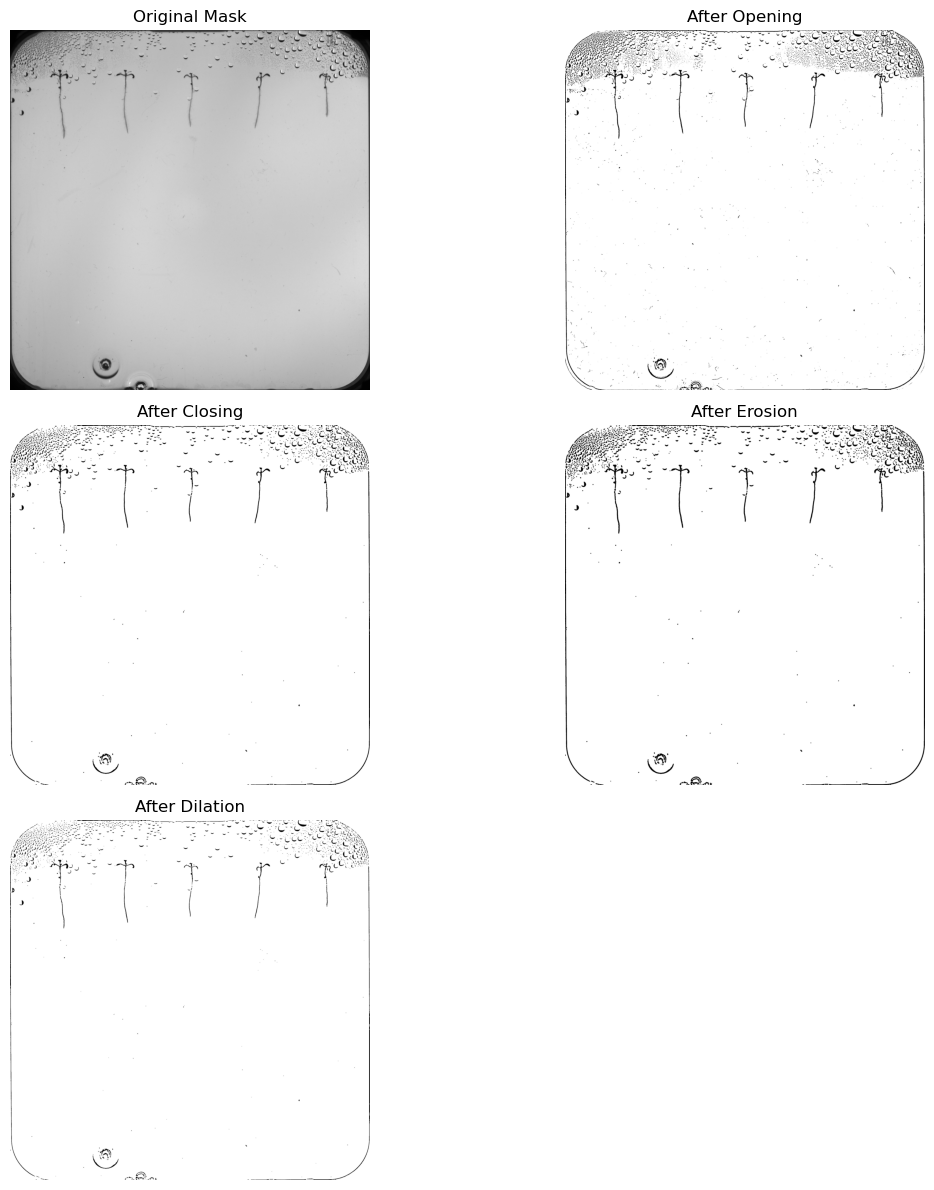

In [140]:
# Define kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # small, round shape

# 1. Opening (remove small noise)
opened = cv2.morphologyEx(thresh_gauss, cv2.MORPH_OPEN, kernel, iterations=1)

# 2. Closing (fill small gaps in roots)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=2)

# Step 3: Erosion (shrink + separate)
eroded = cv2.erode(closed, kernel, iterations=1)

# Step 4: Dilation to slightly thicken the structures
dilated = cv2.dilate(closed, kernel, iterations=1)

# Visualize
titles = ['Original Mask', 'After Opening', 'After Closing', 'After Erosion', 'After Dilation']
images = [cropped, opened, closed, eroded, dilated]

plt.figure(figsize=(12, 12))
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Closing is definitely the way to go here because all roots are clearly preserved after, the shape looks strong but not overpowering with the background like the other images, noise is naturally surpressed, and root sillhouettes are easier to isolate.

---

*Winner: Closing*

## 5. Connected componnents

Since the adaptive thresholding step often produces white backgrounds and black plants. I will invert the mask to ensure plants appear white (foreground) and background black.

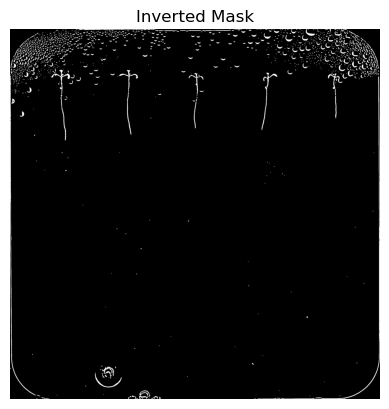

In [137]:
# Invert the binary mask
inverted_mask = cv2.bitwise_not(closed)

# Display the inverted mask
plt.imshow(inverted_mask, cmap='gray')
plt.title("Inverted Mask")
plt.axis('off')
plt.show()

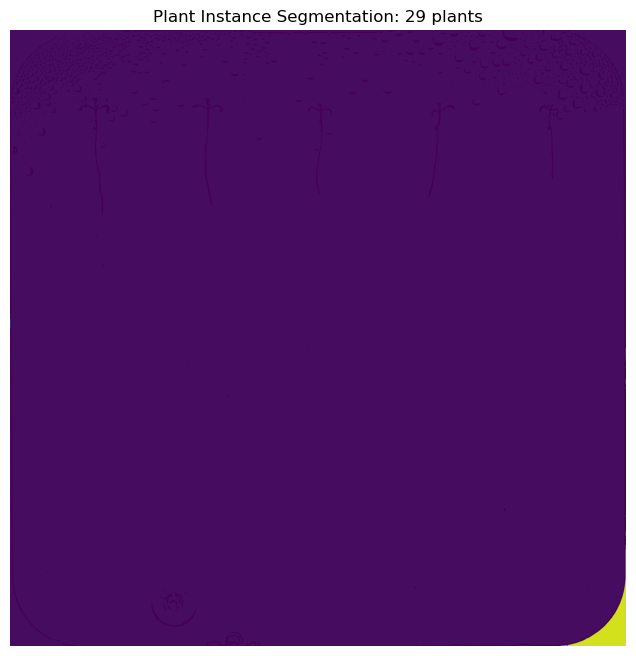

In [144]:
# Connected Components
num_labels, labels = cv2.connectedComponents(closed)

# Plot using a perceptually uniform colormap
plt.figure(figsize=(8, 8))
plt.imshow(labels, cmap='viridis')
plt.axis('off')
plt.title(f'Plant Instance Segmentation: {num_labels - 1} plants')
plt.show()

---

Conclusions:
- *Plants are barely visible*: After applying adaptive thresholding and morphological operations, some plant structures—especially fine roots or central plants—became too faint or fragmented to be detected as full components.
- *The pietri dish got confused as a component*: Because the outer ring of the dish is high-contrast and continuous, the connected components algorithm picked it up as a large object, mistaking it for a root instance.
- *Over-processing*: Since blurring is already happenning inside of the `crop_image` function, it might be redundant to apply other types of blurring.

Steps to take:
- Adaptive thresholding is not good. Although it preserved all roots initially, it also preserved too much background noise and failed to clearly separate plants from the Petri dish. It’s now clear that the overall contrast it introduced isn’t helpful at this stage.
- Filter by area to remove small components like dust or droplets and (hopefully) exclude the large ones, like the pietri dish ring.
- Apply labels for each plant instance.

# Phase 2: Polishing

## 1. Import image & Crop

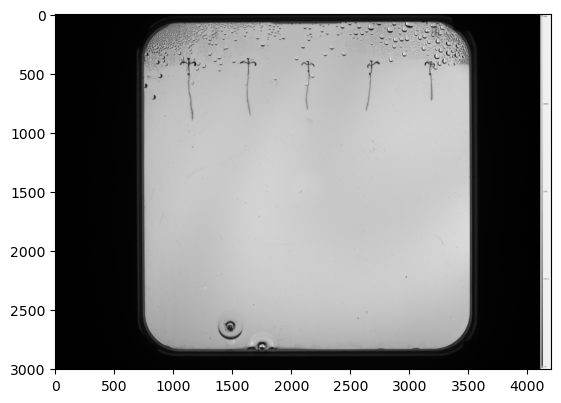

In [145]:
# IMAGE TO BE USED FOR POlISHING
image_path = "/Volumes/Capybara/2024-25b-fai2-adsai-dariavladutu236578/datalab_tasks/task3/task_3_image_1.png"
im = cv2.imread(image_path, 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)
plt.imshow(im, cmap='gray')

In [146]:
# Apply function
cropped = crop_image(image_path)

## 2. NO noise reduction

## 3. Thresholding using Otsu

In [149]:
_, othresh = cv2.threshold(cropped, 164, 255, cv2.THRESH_BINARY_INV)

## 4. Connected components (filtering for small components)

Here I used the `cv2.connectedComponentsWithStats()` to remove small components. The `min_area` that was selected was chosen based on trial-and-error. 

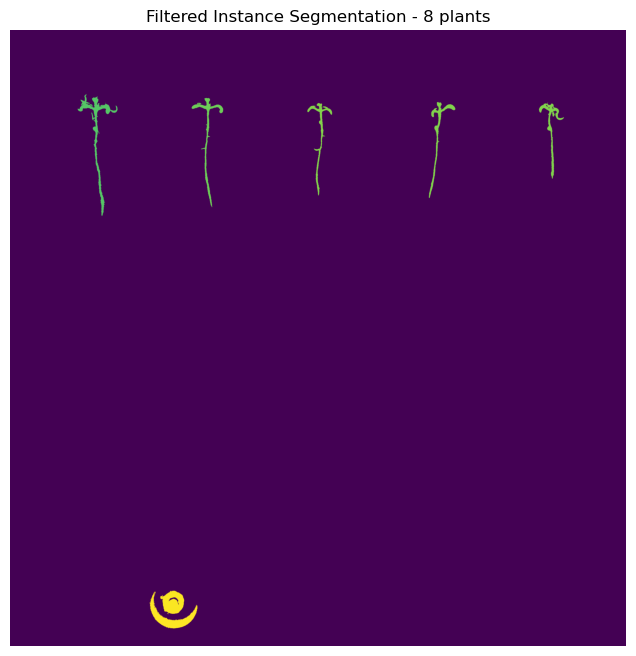

In [157]:
# Run connected components with stats
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(othresh)

# Create an output image where we'll only keep large components
filtered_labels = np.zeros_like(labels)

# Define area threshold
min_area = 5000

for i in range(1, num_labels):  # skip background (label 0)
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_labels[labels == i] = i

# Visualize
plt.figure(figsize=(8, 8))
plt.imshow(filtered_labels, cmap='viridis')  # or any other colormap
plt.title(f'Filtered Instance Segmentation - {np.unique(filtered_labels).size - 1} plants')
plt.axis('off')
plt.show()

---

It has detected 8 plants and a bubble from the background was still confused as a component.

# Phase 3: New approach

I decided to use a tighter bounding box position filter, based on vertical location as roots are always near the top of the image and they are always vertical. I assumed there will always be a rectangle that follows the formula h=2*w. 
There are also always 5 plants. Therefore, we look for the top 5 bounding boxes (assuming the plants will always be the largest).

In [172]:
# Define aspect ratio threshold (h=2*w)
aspect_ratio_threshold = 2 

# Calculate the bounding box area for each component
bounding_box_areas = [(stats[i][2] * stats[i][3], i) for i in range(1, num_labels)]
bounding_box_areas_sorted = sorted(bounding_box_areas, key=lambda x: x[0], reverse=True) 

# Filter out components based on aspect ratio and keep only the top 5 with largest bounding box area
top_5_labels = []
for _, label in bounding_box_areas_sorted:
    x, y, w, h, _ = stats[label]
    aspect_ratio = h / w if w > 0 else 0  # Prevent division by zero
    if aspect_ratio > aspect_ratio_threshold: # Verticle rectangle check
        top_5_labels.append(label)
    if len(top_5_labels) == 5:
        break

# Print selected labels
print("Top 5 selected labels:", top_5_labels)

Top 5 selected labels: [2079, 2204, 2287, 2299, 2295]


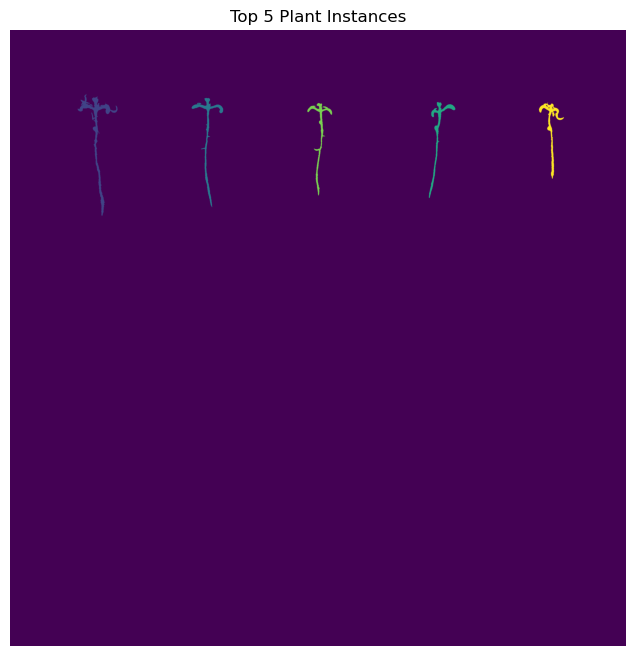

In [173]:
# Initialize an empty output array with the same shape as the label image
output = np.zeros_like(labels, dtype=np.uint8)

# Assign a unique integer label (1 to 5) to each selected plant component
counter = 1
for cc_id in top_5_labels:
    output[labels == cc_id] = counter
    counter += 1

# Display the final labeled output
plt.figure(figsize=(8,8))
plt.imshow(output)
plt.title("Top 5 Plant Instances")
plt.axis('off')
plt.show()


## Safety check with the second image

Top 5 selected labels: [893, 997, 780, 988, 2256]


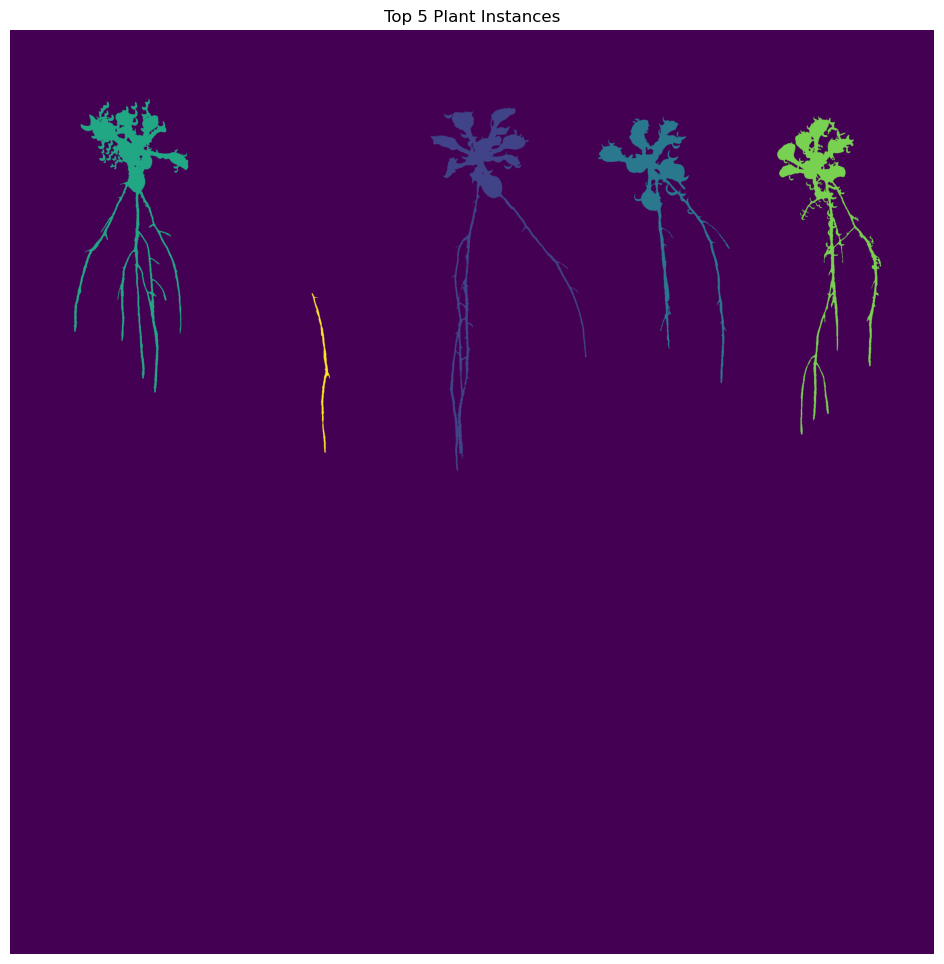

In [183]:
def crop_image (image):
    # read the image in grayscale
    im = cv2.imread(image, 0)

    # apply Gaussian Blur
    blur = cv2.GaussianBlur(im, (5,5), 0)

    # threshold the image to detect the edges of the Petri dish
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # select the largest contour (assume that is the pietri dish)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]

    # get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # ensure the bounding box is square
    square_size = max(w, h)

    # ensure the bounding box is centered
    x_center = x + w // 2
    y_center = y + h // 2

    x_start = max(x_center - square_size // 2, 0)
    y_start = max(y_center - square_size // 2, 0)

    # crop the image
    cropped_image = im[y_start:y_start+square_size, x_start:x_start+square_size]

    return cropped_image

# Load image
image_path = "/Volumes/Capybara/2024-25b-fai2-adsai-dariavladutu236578/datalab_tasks/task3/task_3_image_2.png"
im = cv2.imread(image_path, 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Apply function
cropped = crop_image(image_path)

# Apply thresholding using Otsu
_, othresh = cv2.threshold(cropped, 164, 255, cv2.THRESH_BINARY_INV)

# Run connected components with stats
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(othresh)

# Create an output image where we'll only keep large components
filtered_labels = np.zeros_like(labels)

# Define area threshold
min_area = 5000

for i in range(1, num_labels):  # skip background (label 0)
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_labels[labels == i] = i

# Define aspect ratio threshold (h=2*w)
aspect_ratio_threshold = 2 

# Calculate the bounding box area for each component
bounding_box_areas = [(stats[i][2] * stats[i][3], i) for i in range(1, num_labels)]
bounding_box_areas_sorted = sorted(bounding_box_areas, key=lambda x: x[0], reverse=True) 

# Filter out components based on aspect ratio and keep only the top 5 with largest bounding box area
top_5_labels = []
for _, label in bounding_box_areas_sorted:
    x, y, w, h, _ = stats[label]
    aspect_ratio = h / w if w > 0 else 0  # Prevent division by zero
    if aspect_ratio > aspect_ratio_threshold: # Verticle rectangle check
        top_5_labels.append(label)
    if len(top_5_labels) == 5:
        break

# Print selected labels
print("Top 5 selected labels:", top_5_labels)

# Initialize an empty output array with the same shape as the label image
output = np.zeros_like(labels, dtype=np.uint8)

# Assign a unique integer label (1 to 5) to each selected plant component
counter = 1
for cc_id in top_5_labels:
    output[labels == cc_id] = counter
    counter += 1

# Display the final labeled output
plt.figure(figsize=(12,12))
plt.imshow(output)
plt.title("Top 5 Plant Instances")
plt.axis('off')
plt.show()

I played around with the min_area for the threshold and, after not working at all, I decided to scrap it. Instead of only cosidering the components that pass my own min_area check, all of them will be included and I will ONLY selct the 5 largest bounding box areas with a valid aspect ratio.
I also lowered the `aspect_ratio_threshold` to 1.5. I decided to do this because setting it to 2, as it only lets very narrow, tall components instead of wider ones.

## Phase 4: Final pipeline

Top 5 selected labels: [893, 882, 997, 780, 988]


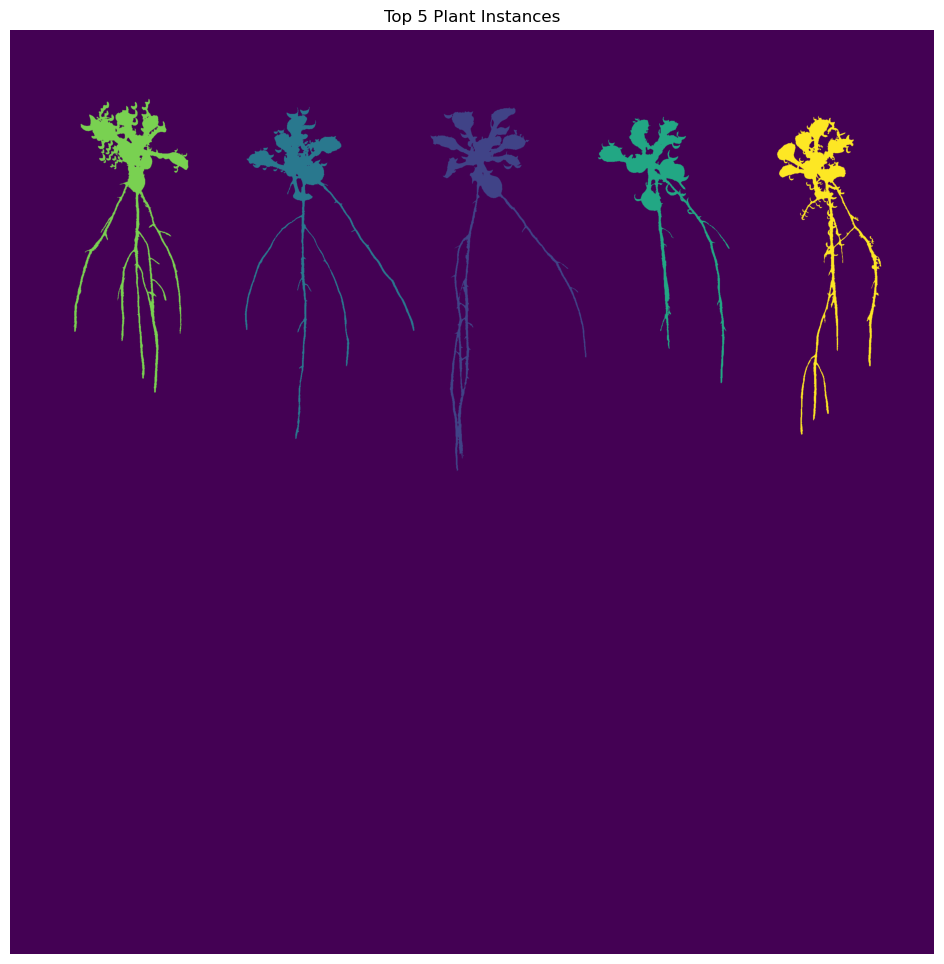

In [186]:
def crop_image (image):
    # read the image in grayscale
    im = cv2.imread(image, 0)

    # apply Gaussian Blur
    blur = cv2.GaussianBlur(im, (5,5), 0)

    # threshold the image to detect the edges of the Petri dish
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # select the largest contour (assume that is the pietri dish)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]

    # get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # ensure the bounding box is square
    square_size = max(w, h)

    # ensure the bounding box is centered
    x_center = x + w // 2
    y_center = y + h // 2

    x_start = max(x_center - square_size // 2, 0)
    y_start = max(y_center - square_size // 2, 0)

    # crop the image
    cropped_image = im[y_start:y_start+square_size, x_start:x_start+square_size]

    return cropped_image

# Load image
image_path = "/Volumes/Capybara/2024-25b-fai2-adsai-dariavladutu236578/datalab_tasks/task3/task_3_image_2.png"
im = cv2.imread(image_path, 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Apply function
cropped = crop_image(image_path)

# Apply thresholding using Otsu
_, othresh = cv2.threshold(cropped, 164, 255, cv2.THRESH_BINARY_INV)

# Run connected components with stats
aspect_ratio_threshold = 1.5
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(othresh)

# Calculate the bounding box area for each component
bounding_box_areas = [(stats[i][2] * stats[i][3], i) for i in range(1, num_labels)]
bounding_box_areas_sorted = sorted(bounding_box_areas, key=lambda x: x[0], reverse=True) 

# Filter out components based on aspect ratio and keep only the top 5 with largest bounding box area
top_5_labels = []
for _, label in bounding_box_areas_sorted:
    x, y, w, h, _ = stats[label]
    aspect_ratio = h / w if w > 0 else 0  # Prevent division by zero
    if aspect_ratio > aspect_ratio_threshold: # Verticle rectangle check
        top_5_labels.append(label)
    if len(top_5_labels) == 5:
        break

# Print selected labels
print("Top 5 selected labels:", top_5_labels)

# Initialize an empty output array with the same shape as the label image
output = np.zeros_like(labels, dtype=np.uint8)

# Assign a unique integer label (1 to 5) to each selected plant component
counter = 1
for cc_id in top_5_labels:
    output[labels == cc_id] = counter
    counter += 1

# Display the final labeled output
plt.figure(figsize=(12,12))
plt.imshow(output)
plt.title("Top 5 Plant Instances")
plt.axis('off')
plt.show()

Top 5 selected labels: [2079, 2204, 2287, 2299, 2295]


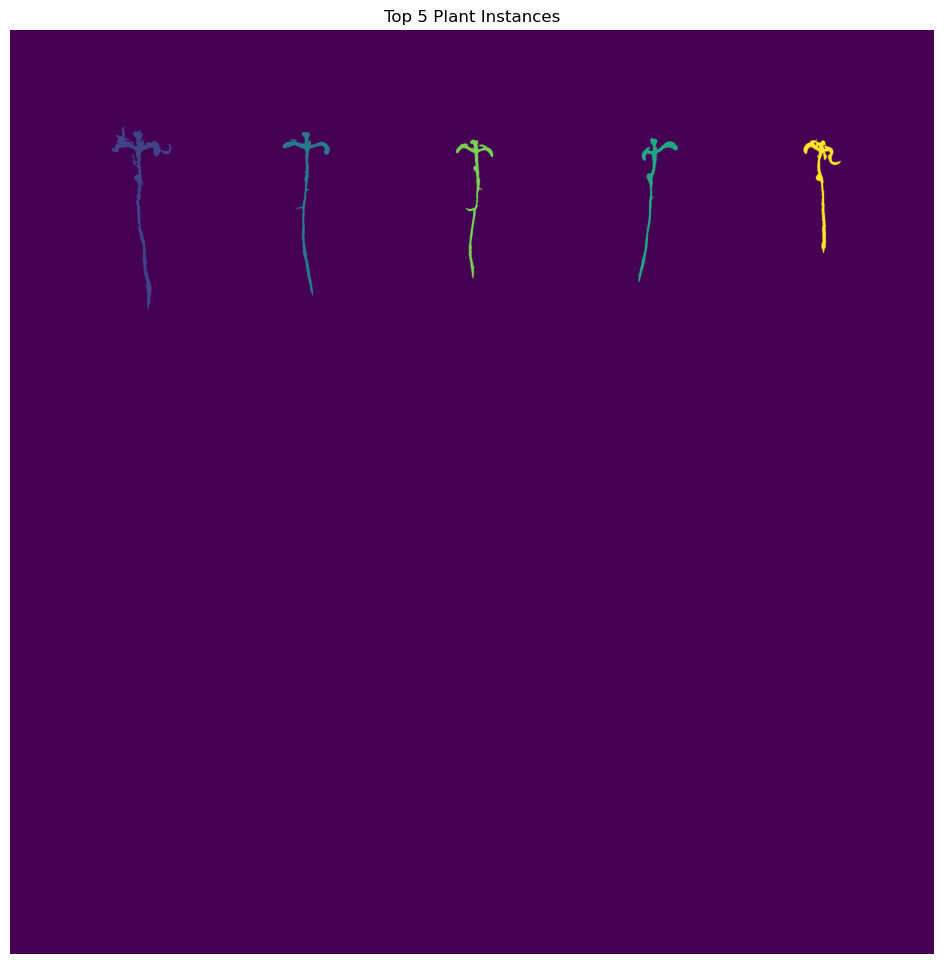

In [175]:
def crop_image (image):
    # read the image in grayscale
    im = cv2.imread(image, 0)

    # apply Gaussian Blur
    blur = cv2.GaussianBlur(im, (5,5), 0)

    # threshold the image to detect the edges of the Petri dish
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # select the largest contour (assume that is the pietri dish)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]

    # get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # ensure the bounding box is square
    square_size = max(w, h)

    # ensure the bounding box is centered
    x_center = x + w // 2
    y_center = y + h // 2

    x_start = max(x_center - square_size // 2, 0)
    y_start = max(y_center - square_size // 2, 0)

    # crop the image
    cropped_image = im[y_start:y_start+square_size, x_start:x_start+square_size]

    return cropped_image

# Load image
image_path = "/Volumes/Capybara/2024-25b-fai2-adsai-dariavladutu236578/datalab_tasks/task3/task_3_image_1.png"
im = cv2.imread(image_path, 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Apply function
cropped = crop_image(image_path)

# Apply thresholding using Otsu
_, othresh = cv2.threshold(cropped, 164, 255, cv2.THRESH_BINARY_INV)

# Run connected components with stats
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(othresh)

# Calculate the bounding box area for each component
bounding_box_areas = [(stats[i][2] * stats[i][3], i) for i in range(1, num_labels)]
bounding_box_areas_sorted = sorted(bounding_box_areas, key=lambda x: x[0], reverse=True) 

# Filter out components based on aspect ratio and keep only the top 5 with largest bounding box area
top_5_labels = []
for _, label in bounding_box_areas_sorted:
    x, y, w, h, _ = stats[label]
    aspect_ratio = h / w if w > 0 else 0  # Prevent division by zero
    if aspect_ratio > aspect_ratio_threshold: # Verticle rectangle check
        top_5_labels.append(label)
    if len(top_5_labels) == 5:
        break

# Print selected labels
print("Top 5 selected labels:", top_5_labels)

# Initialize an empty output array with the same shape as the label image
output = np.zeros_like(labels, dtype=np.uint8)

# Assign a unique integer label (1 to 5) to each selected plant component
counter = 1
for cc_id in top_5_labels:
    output[labels == cc_id] = counter
    counter += 1

# Display the final labeled output
plt.figure(figsize=(12,12))
plt.imshow(output)
plt.title("Top 5 Plant Instances")
plt.axis('off')
plt.show()